In [1]:
from python.commons import *

In [1]:


def setup_3way_cut_problem(G, terminals):
    try:
        # Initialize CPLEX problem
        prob = cplex.Cplex()
        prob.set_problem_type(cplex.Cplex.problem_type.LP)
        prob.objective.set_sense(prob.objective.sense.minimize)

        # Add variables
        edge_vars = {}
        node_partition_vars = {}
        for i in G.nodes():
            if i in terminals:
                continue  # Skip terminals
            for t in range(3):  # For each terminal/partition
                var_name = f"x_{i}_{t}"
                node_partition_vars[(i, t)] = var_name
                prob.variables.add(names=[var_name], lb=[0], ub=[1], types=["B"])

        for i, j in G.edges():
            var_name = f"y_{i}_{j}"
            edge_vars[(i, j)] = var_name
            prob.variables.add(names=[var_name], lb=[0], ub=[1], types=["B"], obj=[G[i][j]['weight']])

        # Add constraints
        # Node must belong to one partition
        for i in G.nodes():
            if i in terminals:
                continue
            constraints = [node_partition_vars[(i, t)] for t in range(3)]
            prob.linear_constraints.add(
                lin_expr=[cplex.SparsePair(ind=constraints, val=[1]*3)],
                senses=["E"],
                rhs=[1]
            )

        # Edge cut constraints
        for i, j in G.edges():
            for t in range(3):
                prob.linear_constraints.add(
                    lin_expr=[
                        cplex.SparsePair(ind=[node_partition_vars[(i, t)], node_partition_vars[(j, t)], edge_vars[(i, j)]],
                                         val=[1, -1, 1]),
                        cplex.SparsePair(ind=[node_partition_vars[(i, t)], node_partition_vars[(j, t)], edge_vars[(i, j)]],
                                         val=[-1, 1, 1])
                    ],
                    senses="LL",
                    rhs=[0, 0]
                )

        # Solve the problem
        prob.solve()
        return prob

    except CplexError as exc:
        print(exc)
        return None

# # Example usage
# G = ...  # Your graph initialization here
# terminals = ['t1', 't2', 't3']  # Your terminals
# problem = setup_3way_cut_problem(G, terminals)
# if problem:
#     # Extract solution, etc.
#     print("Solution status = ", problem.solution.get_status(), ":", end=' ')
#     print(problem.solution.status[problem.solution.get_status()])
#     print("Solution value  = ", problem.solution.get_objective_value())
    # Further extraction of partition assignments, etc., can be done here


# Generic Max cut Cplex algorithm

In [18]:



# Function to find the max cut using CPLEX
def find_max_cut(G):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    edges = list(G.edges(data=True))

    # CPLEX Model
    model = cplex.Cplex()
    model.set_problem_type(cplex.Cplex.problem_type.LP)

    # Variables
    x_vars = ["x_" + str(i) for i in range(num_nodes)]
    model.variables.add(names=x_vars, types=[model.variables.type.binary] * num_nodes)

    y_vars = ["y_" + str(i) for i in range(num_edges)]
    model.variables.add(names=y_vars, types=[model.variables.type.binary] * num_edges)

    # Objective function
    objective = [edge[2]['weight'] for edge in edges]
    model.objective.set_sense(model.objective.sense.maximize)
    model.objective.set_linear(list(zip(y_vars, objective)))

    # Constraints for edges
    for idx, (u, v, _) in enumerate(edges):
        model.linear_constraints.add(
            lin_expr=[[["x_" + str(u), "x_" + str(v), "y_" + str(idx)], [1.0, 1.0, -1.0]]],
            senses=["L"],
            rhs=[1.0]
        )
        model.linear_constraints.add(
            lin_expr=[[["x_" + str(u), "x_" + str(v), "y_" + str(idx)], [1.0, 1.0, 1.0]]],
            senses=["G"],
            rhs=[1.0]
        )

    try:
        model.solve()
    except CplexError as exc:
        print(exc)
        return

    # Solution
    x_sol = model.solution.get_values(x_vars)
    y_sol = model.solution.get_values(y_vars)
    max_cut_value = model.solution.get_objective_value()

    # Extracting the cut
    cut = [i for i in range(num_nodes) if x_sol[i] > 0.5]
    other_set = [i for i in range(num_nodes) if x_sol[i] <= 0.5]

    return cut, other_set, max_cut_value



G = generate_graph(n=80, d=3, p=None, graph_type='reg', random_seed=1)
for u, v, d in G.edges(data=True):
    d['weight'] = 1
    d['capacity'] = 1
# Find max cut
cut, other_set, max_cut_value = find_max_cut(G)
print("Set 1:", cut)
print("Set 2:", other_set)
print("Max Cut Value:", max_cut_value)

Generating d-regular graph with n=80, d=3, seed=1
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 120.000000 after 0.00 sec. (0.01 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.02 ticks)
Parallel b&c, 10 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.02 ticks)
Set 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Set 2: []
Max Cut Value: 120.0


In [7]:
def generate_graph(n, d=None, p=None, graph_type='reg', random_seed=0):
    """
    Helper function to generate a NetworkX random graph of specified type,
    given specified parameters (e.g. d-regular, d=3). Must provide one of
    d or p, d with graph_type='reg', and p with graph_type in ['prob', 'erdos'].

    Input:
        n: Problem size
        d: [Optional] Degree of each node in graph
        p: [Optional] Probability of edge between two nodes
        graph_type: Specifies graph type to generate
        random_seed: Seed value for random generator
    Output:
        nx_graph: NetworkX OrderedGraph of specified type and parameters
    """
    if graph_type == 'reg':
        print(f'Generating d-regular graph with n={n}, d={d}, seed={random_seed}')
        nx_temp = nx.random_regular_graph(d=d, n=n, seed=random_seed)
    elif graph_type == 'reg_random':
        print(f'Generating d-regular random graph with n={n}, d={d}')
        nx_temp = nx.random_regular_graph(d=d, n=n)
    elif graph_type == 'prob':
        print(f'Generating p-probabilistic graph with n={n}, p={p}, seed={random_seed}')
        nx_temp = nx.fast_gnp_random_graph(n, p, seed=random_seed)
    elif graph_type == 'erdos':
        print(f'Generating erdos-renyi graph with n={n}, p={p}, seed={random_seed}')
        nx_temp = nx.erdos_renyi_graph(n, p, seed=random_seed)
    else:
        raise NotImplementedError(f'!! Graph type {graph_type} not handled !!')

    # Networkx does not enforce node order by default
    nx_temp = nx.relabel.convert_node_labels_to_integers(nx_temp)
    # Need to pull nx graph into OrderedGraph so training will work properly
    nx_graph = nx.Graph()
    nx_graph.add_nodes_from(sorted(nx_temp.nodes()))
    nx_graph.add_edges_from(nx_temp.edges)
    nx_graph.order()
    return nx_graph

G = generate_graph(n=80, d=3, p=None, graph_type='reg', random_seed=1)
for u, v, d in G.edges(data=True):
    d['weight'] = 1
    d['capacity'] = 1

Generating d-regular graph with n=80, d=3, seed=1


In [5]:

import matplotlib.pyplot as plt

# Function to draw the graph with partitions and edge weights
def draw_graph_with_partitions(G, partitions):
    # Create a color map for the partitions
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange']
    node_colors = {}

    for idx, partition in enumerate(partitions):
        for node in partition:
            node_colors[node] = colors[idx % len(colors)]

    # Draw the graph
    pos = nx.spring_layout(G)
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}

    nx.draw(G, pos, with_labels=True, node_color=[node_colors[node] for node in G.nodes()], edge_color='black')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

In [10]:
import networkx as nx
import cplex
from cplex.exceptions import CplexError

# Create a NetworkX graph
# G = nx.Graph()
#
# # Add edges to the graph (example graph)
# G.add_edges_from([
#     (0, 1, {'weight': 1}),
#     (0, 2, {'weight': 2}),
#     (1, 2, {'weight': 3}),
#     (1, 3, {'weight': 4}),
#     (2, 3, {'weight': 5})
# ])
#
# # List of terminal nodes
# terminals = [0, 1, 2]

# Function to find the multi-way max cut using CPLEX with terminal node constraints
def find_multiway_max_cut(G, terminals):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    num_terminals = len(terminals)

    edges = list(G.edges(data=True))

    # CPLEX Model
    model = cplex.Cplex()
    model.set_problem_type(cplex.Cplex.problem_type.LP)

    # Variables for partition assignments
    x_vars = [["x_{}_{}".format(i, k) for k in range(num_terminals)] for i in range(num_nodes)]
    x_flat_vars = [var for sublist in x_vars for var in sublist]
    model.variables.add(names=x_flat_vars, types=[model.variables.type.binary] * len(x_flat_vars))

    # Variables for edges in the cut
    y_vars = ["y_" + str(i) for i in range(num_edges)]
    model.variables.add(names=y_vars, types=[model.variables.type.binary] * num_edges)

    # Objective function
    objective = [edge[2]['weight'] for edge in edges]
    model.objective.set_sense(model.objective.sense.maximize)
    model.objective.set_linear(list(zip(y_vars, objective)))

    # Constraints for edges
    for idx, (u, v, _) in enumerate(edges):
        for k in range(num_terminals):
            model.linear_constraints.add(
                lin_expr=[[["x_{}_{}".format(u, k), "x_{}_{}".format(v, k), "y_" + str(idx)], [1.0, 1.0, -1.0]]],
                senses=["L"],
                rhs=[1.0]
            )

    # Each node must be in exactly one partition
    for i in range(num_nodes):
        model.linear_constraints.add(
            lin_expr=[[["x_{}_{}".format(i, k) for k in range(num_terminals)], [1.0] * num_terminals]],
            senses=["E"],
            rhs=[1.0]
        )

    # Each terminal must be in a unique partition
    for k in range(num_terminals):
        terminal = terminals[k]
        model.linear_constraints.add(
            lin_expr=[[["x_{}_{}".format(terminal, k)], [1.0]]],
            senses=["E"],
            rhs=[1.0]
        )

    try:
        model.solve()
    except CplexError as exc:
        print(exc)
        return

    # Solution
    x_sol = model.solution.get_values(x_flat_vars)
    y_sol = model.solution.get_values(y_vars)
    max_cut_value = model.solution.get_objective_value()

    # Extracting the partitions
    partitions = [[] for _ in range(num_terminals)]
    for i in range(num_nodes):
        for k in range(num_terminals):
            if x_sol[i * num_terminals + k] > 0.5:
                partitions[k].append(i)

    return partitions, max_cut_value

# Find multi-way max cut with terminal constraints
partitions, max_cut_value = find_multiway_max_cut(G, [10,30,60])
for idx, partition in enumerate(partitions):
    print("Partition {}: {}".format(idx, partition))
print("Max Cut Value:", max_cut_value)


Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 2.000000 after 0.00 sec. (0.05 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 443 rows and 360 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.29 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.35 ticks)
Parallel b&c, 10 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.35 ticks)
Partition 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Partition 1: [30]
Partition 2: [60

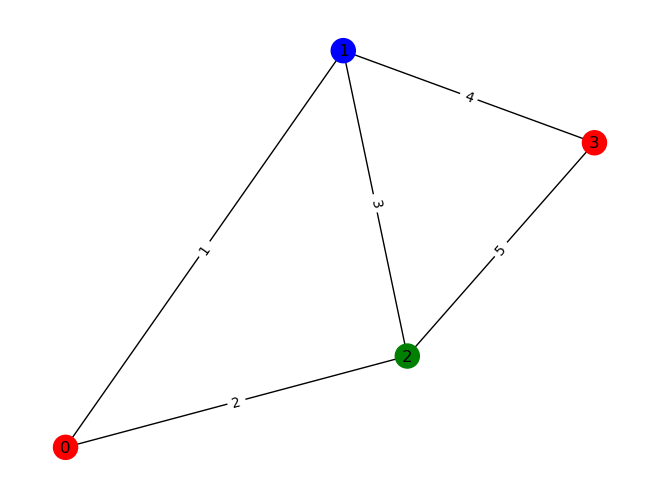

In [6]:
draw_graph_with_partitions(G, partitions)

In [21]:
from docplex.mp.model import Model
import random

# Parameters
n = 400
edge_prob = 0.5
weight_range = 10
big = 100000

# Random graph generation
random.seed(42)
edges = [(i, j) for i in range(1, n+1) for j in range(i+1, n+1)]
weights = {(i, j): (random.randint(1, weight_range) if random.random() <= edge_prob else 0)
           for i, j in edges}

# Initialize the model
model = Model('ThreePartitionGraph')

# Decision variables: x[i] can take values 0, 1, or 2
x = model.integer_var_dict(range(1, n+1), lb=0, ub=2, name="x")

# Objective function: maximize the sum of edge weights between different partitions
model.maximize(model.sum(weights[i, j] * (x[i] != x[j]) for i, j in edges))

# Constraints to define specific nodes in partitions
model.add_constraint(x[1] == 1)
model.add_constraint(x[2] == 0)

# Solve the model
solution = model.solve()

# Output results
if solution:
    x_values = solution.get_values(x)
    x1 = [i for i in range(1, n+1) if x_values[i-1] == 1]
    x0 = [i for i in range(1, n+1) if x_values[i-1] == 0]

    print("Objective value:", solution.objective_value)
    print("Nodes in partition 1 (x=1):", x1)
    print("Nodes in partition 0 (x=0):", x0)
else:
    print("No solution found.")


DOcplexLimitsExceeded: **** Promotional version. Problem size limits (1000 vars, 1000 consts) exceeded, model has 160000 vars, 159602 consts, CPLEX code=1016

In [21]:

from docplex.cp.model import CpoModel, CpoParameters
from docplex.cp.expression import integer_var_list


def cplex_code_graph(G):
    context.solver.agent = 'local'
    context.solver.local.execfile = '/Applications/CPLEX_Studio2211/cpoptimizer/bin/arm64_osx/cpoptimizer'
    # Define model
    model = CpoModel(name="multiMax")
    # model.set_time_limit(20)
    
    # Parameters
    n = G.number_of_nodes()
    r = range(n)
    
    # Read edges data from CSV
    # edges_df = pd.read_csv("./test_graph_4000Set4.csv", header=None, names=["i", "j", "weight"])
    # print(edges_df)
    # print(edges_df.iloc[0])
    # print(edges_df['i'].values)
    # Convert edges data into tuple list
    print("populating edges")
    # edges = [(int(row["i"]), int(row["j"]), float(row["weight"])) for _, row in edges_df[1:].iterrows()]
    
    # Initialize the weight matrix
    w = [[0.0 for _ in r] for _ in r]
    
    print("populating weight data")
    # Populate the weight matrix based on the loaded data
    for u,v,d in G.edges(data=True):
        # i, j, weight = edge
        w[u][v] = d['weight']
        w[v][u] = d['weight']  # Assuming the graph is undirected
    
    print("setting up the model")
    # Define decision variables
    x = integer_var_list(n, 0, 2, name="x")
    
    print("setting up the OBJ")
    print("model", model)
    # Define the objective function
    
    # obj = model.sum(w[i][j] * (x[i] != x[j]) for i in r for j in r if i < j)
    
    
    print("finished setting up the OBJ")
    # model.set_parameter("TimeLimit", 10)
    # model.parameters.timelimit=10;
    # model.set_time_limit(10) #The same
    # print("time limit = ",model.parameters.timelimit.get())
    # print("time limit = ",model.get_time_limit()) #The same
    param=CpoParameters();
    param.set_TimeLimit(300)
    param.TimeLimit=300;
    param.set_SolutionLimit(100)
    model.set_parameters(param)
    # Set objective to maximize
    # model.add(model.maximize(sum(w[i][j] * (x[i] != x[j]) for i in r for j in r if i < j)))
    
    model.add(model.maximize(sum(w[i][j] * (x[i] != x[j]) for i in r for j in r )))


    # model.set_log_stream(None)
    # model.set_error_stream(None)
    # model.set_warning_stream(None)
    # model.set_results_stream(None)
    # Add constraints to break symmetry
    model.add(x[1] == 1)
    model.add(x[0] == 0)
    model.add(x[2] == 2)
    
    
    
    print("Solving")
    
    # Solve model
    solution = model.solve()  # Time limit of 1800 seconds (30 minutes)
    
    # Retrieve solution details
    if solution:
        print(f"Objective value: {solution.get_objective_value()}")
        print(f"Objective value: {solution.get_objective_value()/2}")
        x_values = solution.get_values(x)
    
        # Get nodes in each partition
        x0 = [i for i in r if x_values[i] == 0]
        x1 = [i for i in r if x_values[i] == 1]
        x2 = [i for i in r if x_values[i] == 2]
    
        print(f"x set to 0: {x0}")
        print(f"x set to 1: {x1}")
        print(f"x set to 2: {x2}")
        print(f"Size of set x0: {len(x0)}")
        print(f"Size of set x1: {len(x1)}")
        print(f"Size of set x2: {len(x2)}")
        
        return f"Objective value: {solution.get_objective_value()/2}"
    else:
        print("No solution found")


In [22]:
from docplex.cp.config import context

# Point to the correct CPLEX installation path 682-30
context.solver.local.execfile = "/Applications/CPLEX_Studio2211/cplex/bin/arm64_osx/cplex"

ds = open_file('nx_test_generated_graph_n40_100_d8_12_t500.pkl')
for key, (dgl_graph, adjacency_matrix,graph, terminals) in ds.items():
    print(cplex_code_graph(graph))

populating edges
populating weight data
setting up the model
setting up the OBJ
model multiMax
finished setting up the OBJ
Solving
 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Maximization problem - 98 variables, 3 constraints
 ! SolutionLimit        = 100
 ! TimeLimit            = 300
 ! Initial process time : 0.01s (0.01s extraction + 0.00s propagation)
 !  . Log search space  : 150.6 (before), 150.6 (after)
 !  . Memory usage      : 599.0 kB (before), 599.0 kB (after)
 ! Using parallel search with 10 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         98                 -
 + New bound is 784
                        0         95    1            -
 + New bound is 782
                     1000         53    1         2 != x_29
                     1000         59    2         0  = x_61
 *           556      112  0.0

KeyboardInterrupt: 